In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate
import tensorflow.keras.backend as K

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, image_size=(256, 256), num_classes=2, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.image_paths) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indices]
        
        images, masks = self.__load_data(batch_image_paths, batch_mask_paths)
        return images, masks
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __load_data(self, image_paths, mask_paths):
        images = []
        masks = []
        for img_path, mask_path in zip(image_paths, mask_paths):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is not None and mask is not None:
                img = cv2.resize(img, self.image_size)
                mask = cv2.resize(mask, self.image_size)
                img = img / 255.0
                mask = (mask > 0).astype(int)
                images.append(img)
                masks.append(mask)
        images = np.array(images)
        masks = np.array(masks)
        masks = to_categorical(masks, num_classes=self.num_classes)
        return images, masks

def get_image_mask_paths(data_dir, mask_dir):
    image_paths = []
    mask_paths = []
    categories = ['Pro', 'Pre', 'Early', 'Benign']
    for category in categories:
        cat_image_dir = os.path.join(data_dir, category)
        cat_mask_dir = os.path.join(mask_dir, category)
        for filename in os.listdir(cat_image_dir):
            if filename.endswith(".jpg"):
                img_path = os.path.join(cat_image_dir, filename)
                mask_path = os.path.join(cat_mask_dir, filename)  # Mask has the same filename as the image
                if os.path.exists(mask_path):  # Ensure corresponding mask exists
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
    return image_paths, mask_paths

def compute_class_weights(masks):
    labels = masks.flatten()
    classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes=classes, y=labels)
    return {i: weights[i] for i in range(len(classes))}

def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        return K.categorical_crossentropy(y_true, y_pred) * weights
    return loss

# Paths to data directories
original_dir = r'C:\Users\nikit\Downloads\archive\Original\data'
segmented_dir = r'C:\Users\nikit\Downloads\archive\Segmented'
image_paths, mask_paths = get_image_mask_paths(original_dir, segmented_dir)

# Split data
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Compute class weights based on the first few batches
train_gen_for_weights = DataGenerator(train_image_paths[:256], train_mask_paths[:256], batch_size=256)
train_images_sample, train_masks_sample = train_gen_for_weights.__getitem__(0)
class_weights = compute_class_weights(train_masks_sample.argmax(axis=-1))

# Convert class weights to array
class_weights_array = np.array(list(class_weights.values()))

# Data generators
train_gen = DataGenerator(train_image_paths, train_mask_paths, batch_size=16)
val_gen = DataGenerator(val_image_paths, val_mask_paths, batch_size=16)

def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    b = Conv2D(64, (3, 3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    u1 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, c2])
    u1 = Conv2D(32, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u2 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, c1])
    u2 = Conv2D(16, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(u2)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the model and compile with custom loss
model = build_unet((256, 256, 3), 2)
model.compile(optimizer=Adam(), loss=weighted_categorical_crossentropy(class_weights_array), metrics=['accuracy'])

callbacks = [ModelCheckpoint('best_model1.h5', save_best_only=True), EarlyStopping(patience=10), ReduceLROnPlateau(factor=0.1, patience=5)]
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)


Epoch 1/50
162/162 [==============================] - 661s 4s/step - loss: 22224786.0000 - accuracy: 0.8902 - val_loss: 22414956.0000 - val_accuracy: 0.8254
Epoch 2/50
162/162 [==============================] - 628s 4s/step - loss: 22144596.0000 - accuracy: 0.9001 - val_loss: 22211478.0000 - val_accuracy: 0.8884
Epoch 3/50
162/162 [==============================] - 603s 4s/step - loss: 22133926.0000 - accuracy: 0.9012 - val_loss: 22185398.0000 - val_accuracy: 0.8936
Epoch 4/50
162/162 [==============================] - 593s 4s/step - loss: 22128012.0000 - accuracy: 0.9017 - val_loss: 22258550.0000 - val_accuracy: 0.8847
Epoch 5/50
162/162 [==============================] - 595s 4s/step - loss: 22121822.0000 - accuracy: 0.9031 - val_loss: 22665550.0000 - val_accuracy: 0.7836
Epoch 6/50
162/162 [==============================] - 597s 4s/step - loss: 22121634.0000 - accuracy: 0.9027 - val_loss: 22111020.0000 - val_accuracy: 0.9101
Epoch 7/50
162/162 [==============================] - 592s

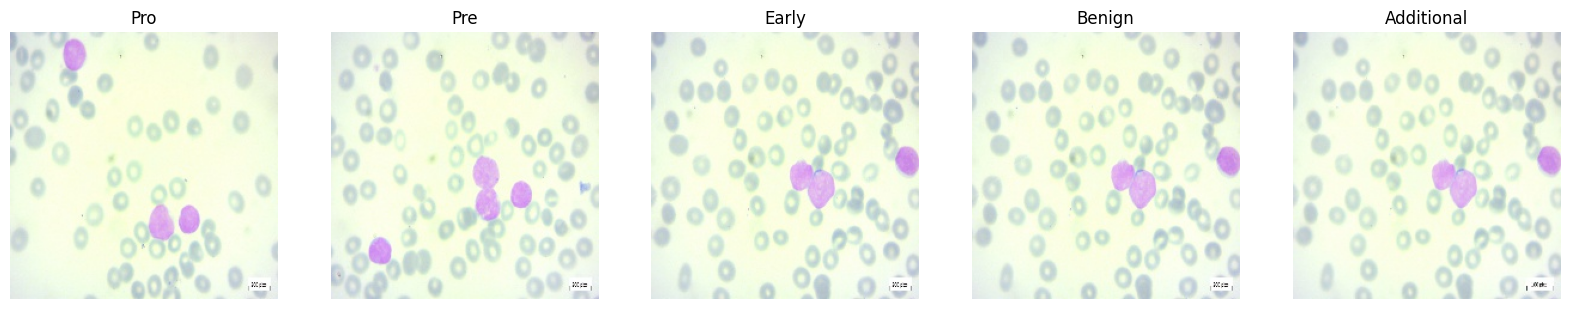

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(images, titles=None):
    fig,axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        if titles is not None:
            ax.set_title(titles[i])
        ax.axis('off')  # Hide axes
    plt.show()

# Assuming you have already loaded image paths
original_dir = r'C:\Users\nikit\Downloads\archive\Original\data'
categories = ['Pro', 'Pre', 'Early', 'Benign']

# Collect the first image from each category to display
image_paths = []
for category in categories:
    cat_image_dir = os.path.join(original_dir, category)
    for filename in os.listdir(cat_image_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(cat_image_dir, filename)
            image_paths.append(img_path)
            if len(image_paths) >= 5:  # Stop after collecting 5 images
                break

# Load and display images
def load_images(image_paths):
    images = []
    for img_path in image_paths[:5]:  # Load only the first 5 images for display
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            images.append(img)
    return images

images = load_images(image_paths)
display_images(images, titles=['Pro', 'Pre', 'Early', 'Benign', 'Additional'])


In [2]:
print("Train Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
best_model = load_model('best_model1.h5', custom_objects={'loss': weighted_categorical_crossentropy(class_weights_array)})
test_loss, test_accuracy = best_model.evaluate(val_gen)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.9068741798400879
Validation Accuracy: 0.9126717448234558
40/40 [==============================] - 27s 668ms/step - loss: 22085492.0000 - accuracy: 0.9124
Test Accuracy: 0.9123650789260864


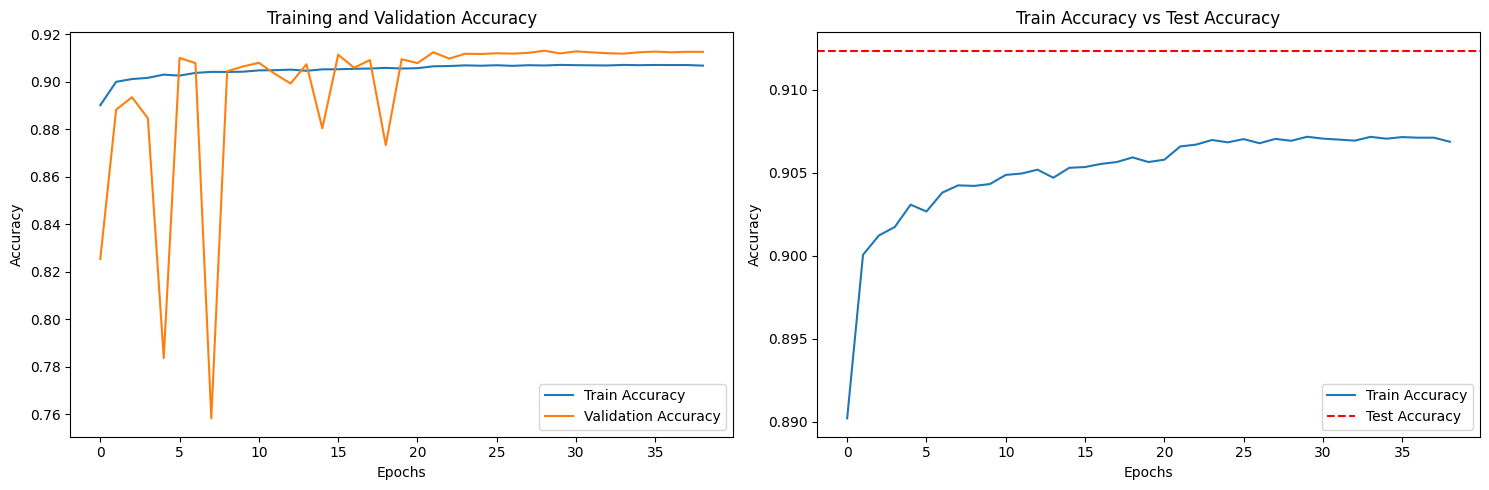

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training vs Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Train vs Test Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
axes[1].set_title('Train Accuracy vs Test Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

val_preds = best_model.predict(val_gen)
val_preds_classes = np.argmax(val_preds, axis=-1)
val_true_classes = np.argmax(np.concatenate([y for x, y in val_gen], axis=0), axis=-1)

# Print classification report
report = classification_report(val_true_classes.flatten(), val_preds_classes.flatten(), target_names=['Benign', 'Malignant'])
print(report)

              precision    recall  f1-score   support

      Benign       0.81      0.85      0.83  33681350
   Malignant       0.21      0.16      0.18   8261690

    accuracy                           0.72  41943040
   macro avg       0.51      0.51      0.50  41943040
weighted avg       0.69      0.72      0.70  41943040

